In [5]:
# 1. Imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os
from datetime import datetime
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [16]:
# 2. Dataset Path & Transforms
data_dir = '../data/ultrasound'   # <-- set this to the parent folder containing normal/, benign/, malignant/

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
# 3. Dataset & DataLoader
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print("Classes:", dataset.classes)  # should print ['benign', 'malignant', 'normal']

Classes: ['benign', 'malignant', 'normal']


In [8]:
# 4. Model Definition
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*32*32, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleCNN(num_classes=len(dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
print("Number of images:", len(dataset))
print("Classes:", dataset.classes)

Number of images: 1578
Classes: ['benign', 'malignant', 'normal']


In [10]:
from collections import Counter
print(Counter(dataset.targets))
print(dataset.classes)

Counter({0: 891, 1: 421, 2: 266})
['benign', 'malignant', 'normal']


In [11]:
imgs, labels = next(iter(dataloader))
print(imgs.shape, labels)

torch.Size([16, 3, 128, 128]) tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


In [17]:
# 5. Training Loop with Accuracy (10 epochs)
from sklearn.metrics import accuracy_score
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    all_preds = []
    all_labels = []
    for imgs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 0.9281, Accuracy: 0.5684
Epoch 2, Loss: 0.7302, Accuracy: 0.6977
Epoch 3, Loss: 0.5389, Accuracy: 0.7744
Epoch 4, Loss: 0.3632, Accuracy: 0.8638
Epoch 5, Loss: 0.2505, Accuracy: 0.9170
Epoch 6, Loss: 0.1380, Accuracy: 0.9512
Epoch 7, Loss: 0.0785, Accuracy: 0.9747
Epoch 8, Loss: 0.0437, Accuracy: 0.9911
Epoch 9, Loss: 0.0259, Accuracy: 0.9918
Epoch 10, Loss: 0.0220, Accuracy: 0.9943


In [ ]:
# Save the trained model weights and architecture
model_path = '../backend/models/simple_cnn_ultrasound.pth'
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'num_classes': len(dataset.classes)}, model_path)
print(f'Model and optimizer state saved to {model_path}')

# To load the model and optimizer later:
checkpoint = torch.load(model_path)
model = SimpleCNN(num_classes=checkpoint['num_classes'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()  # Set to evaluation mode
print('Model loaded and ready for inference.')

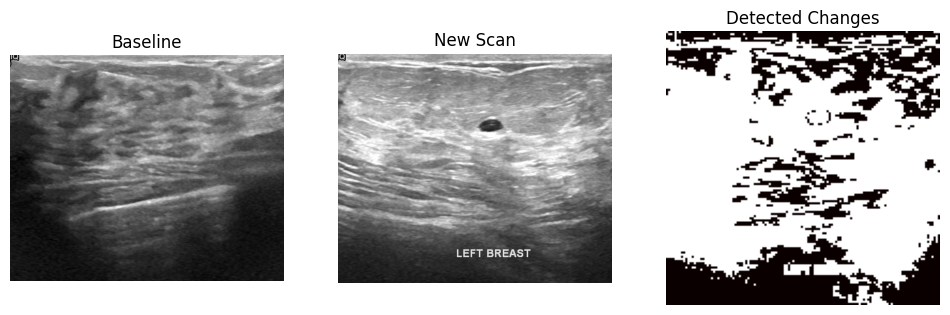

In [12]:


# Paths to baseline and new images
baseline_path = "../userImage/image1.png"  # earlier scan
new_path = "../userImage/image2.png"       # recent scan

# Load and preprocess images
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

baseline_img = Image.open(baseline_path).convert("RGB")
new_img = Image.open(new_path).convert("RGB")

baseline_tensor = transform(baseline_img)
new_tensor = transform(new_img)

# Compute absolute difference
diff = torch.abs(new_tensor - baseline_tensor)

# Threshold to highlight changes
anomaly_mask = (diff > 0.2).float().sum(dim=0)  # sum over channels

# Show images and anomaly mask
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(baseline_img)
axs[0].set_title("Baseline")
axs[1].imshow(new_img)
axs[1].set_title("New Scan")
axs[2].imshow(anomaly_mask, cmap="hot")
axs[2].set_title("Detected Changes")
for ax in axs: ax.axis("off")
plt.show()

In [13]:

def detect_anomaly(img_path, prev_img_path, ssim_threshold=0.85):
    """
    Compare current scan with previous one and detect anomalies.
    Returns a string anomaly type if detected, else None.
    """
    if prev_img_path is None:
        return None  # No comparison for the first image
    # Load images (grayscale for simplicity)
    img1 = cv2.imread(prev_img_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None:
        return "Error: Could not load images"
    # Resize to same shape (if needed)
    img1 = cv2.resize(img1, (256, 256))
    img2 = cv2.resize(img2, (256, 256))
    # Compute SSIM (similarity between images)
    score, diff = ssim(img1, img2, full=True)
    # Check if similarity is too low → anomaly
    if score < ssim_threshold:
        # Heuristic rules to classify anomaly
        diff_mean = np.mean(diff)
        if diff_mean < 0.3:
            return "Image Distortion"
        elif np.mean(cv2.absdiff(img1, img2)) > 25:
            return "Organ Shift"
        else:
            return "Instrument Misalignment"
    return None

# Get scan images and timestamps from file modification time
image_files = ["../userImage/image1.png", "../userImage/image2.png", "../userImage/image3.png"]
scan_images = []
for img in image_files:
    mod_time = os.path.getmtime(img)
    timestamp = datetime.fromtimestamp(mod_time).strftime("%H:%M:%S")
    scan_images.append((img, timestamp))

previous_img_path = None
for img_path, timestamp in scan_images:
    anomaly = detect_anomaly(img_path, previous_img_path)
    if anomaly:
        print(f"Anomaly Detected at {timestamp} - {anomaly}")
    previous_img_path = img_path

Anomaly Detected at 10:44:40 - Image Distortion
Anomaly Detected at 10:44:54 - Image Distortion
